In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from customLib.preprocess import *
from customLib.preprocess import Conv1D as myConv1D
from customLib.peak_detection import *

In [3]:
window_in_seconds = 4.096
fs = 250

In [4]:
SRC = "E:\\ml-data\\masters-thesis\\myDataset\\Patryk\\06-03-24_12_16.npy"
ECG = np.load(SRC)
sliced_signal = slice_signal(signal=ECG, start=0, window_in_seconds=window_in_seconds, fs=fs, overlap_factor=0.25)

In [5]:
Y = []
X = []

for signal in sliced_signal:
    signal = myConv1D(signal=signal, kernel_length=5, padding='same', mode='boundary_value')
    signal = norm_min_max(signal=signal, lower=-1, upper=1)
    r_peaks = detect_my_peaks(signal=signal, threshold=0.5)
    r_peak_indexes = np.zeros_like(signal)
    r_peak_indexes[r_peaks] = 1
    Y.append(r_peak_indexes)
    X.append(signal)

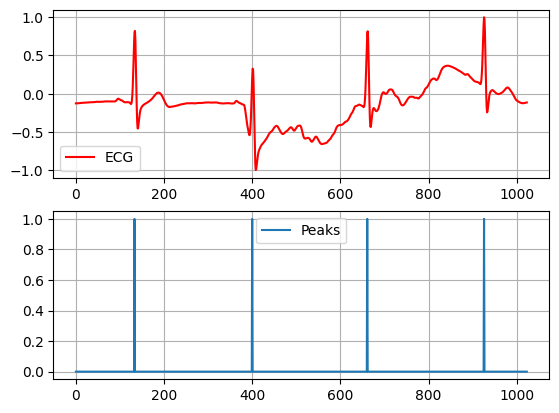

In [6]:
plt.figure(1)
plt.subplot(2,1,1)
plt.grid()
plt.plot(X[10], 'r')
plt.legend(["ECG"])
plt.subplot(2,1,2)
plt.plot(Y[10])
plt.grid()
plt.legend(["Peaks"])

In [7]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv1D(filters=n_filters, kernel_size=3, padding = "same", activation="relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv1D(filters=n_filters, kernel_size=3, padding = "same", activation="relu", kernel_initializer = "he_normal")(x)
   return x
   
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool1D(pool_size=2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv1DTranspose(n_filters, kernel_size=3, strides=2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

In [8]:
inputs = layers.Input(shape=((int(window_in_seconds * fs), 1)))

#koder
f1, p1 = downsample_block(n_filters=16, x=inputs)
f2, p2 = downsample_block(n_filters=32, x=p1)
f3, p3 = downsample_block(n_filters=64, x=p2)

# przestrzeń enkodera
bottleneck = double_conv_block(n_filters=128, x=p3)

#dekoder
u1 = upsample_block(n_filters=64, x=bottleneck, conv_features=f3)
u2 = upsample_block(n_filters=32, x=u1, conv_features=f2)
u3 = upsample_block(n_filters=16, x=u2, conv_features=f1)
outputs = layers.Conv1D(filters=1, kernel_size=1, padding="same", activation="sigmoid")(u3)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X=X, Y=Y, shuffle=True)

In [11]:
model.fit(x=x_train, y=y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
9/9 [==============================] - 5s 181ms/step - loss: 34.1569 - accuracy: 0.5985 - val_loss: 32.2106 - val_accuracy: 0.9713
Epoch 2/20
9/9 [==============================] - 1s 138ms/step - loss: 25.6005 - accuracy: 0.9533 - val_loss: 19.2327 - val_accuracy: 0.9723
Epoch 3/20
9/9 [==============================] - 1s 131ms/step - loss: 17.4724 - accuracy: 0.9839 - val_loss: 16.4380 - val_accuracy: 0.9848
Epoch 4/20
9/9 [==============================] - 1s 135ms/step - loss: 14.9755 - accuracy: 0.9904 - val_loss: 15.1501 - val_accuracy: 0.9889
Epoch 5/20
9/9 [==============================] - 1s 140ms/step - loss: 14.1581 - accuracy: 0.9927 - val_loss: 14.3078 - val_accuracy: 0.9919
Epoch 6/20
9/9 [==============================] - 1s 132ms/step - loss: 13.2977 - accuracy: 0.9947 - val_loss: 13.7720 - val_accuracy: 0.9930
Epoch 7/20
9/9 [==============================] - 1s 141ms/step - loss: 12.7342 - accuracy: 0.9952 - val_loss: 12.5041 - val_accuracy: 0.9957
Epoch 

In [12]:
predictions = model.predict(x_test)

2/2 [==============================] - 0s 28ms/step


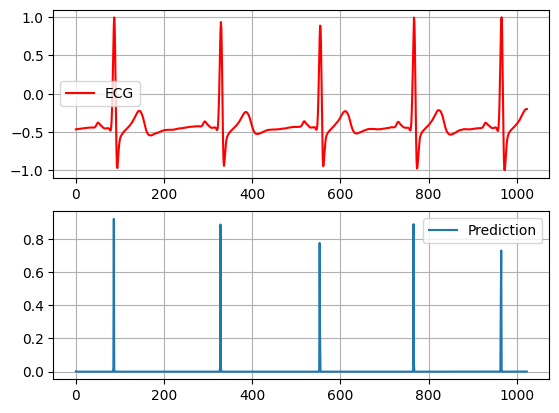

In [14]:
sample = 22
plt.figure(1)
plt.subplot(2,1,1)
plt.plot(x_test[sample][:], 'r')
plt.grid()
plt.legend(["ECG"])
plt.subplot(2,1,2)
plt.plot(predictions[sample][:])
plt.grid()
plt.legend(["Prediction"])

In [15]:
newECG = np.load("E:\\ml-data\\masters-thesis\\myDataset\\Kacper\\29-02-24_21_48.npy")

sliced_signal = slice_signal(signal=newECG, start=0, window_in_seconds=window_in_seconds, fs=fs, overlap_factor=0.2)

newX = []
newY = []

for signal in sliced_signal:
  signal = myConv1D(signal=signal, kernel_length=5, padding='same', mode='boundary_value')
  signal = norm_min_max(signal=signal, lower=-1, upper=1)
  r_peaks = detect_my_peaks(signal=signal, threshold=0.5)
  r_peak_indexes = np.zeros_like(signal)
  r_peak_indexes[r_peaks] = 1
  newY.append(r_peak_indexes)
  newX.append(signal)

newX = np.array(newX)
newY = np.array(newY)

In [16]:
predictions = model.predict(newX)

2/2 [==============================] - 0s 24ms/step


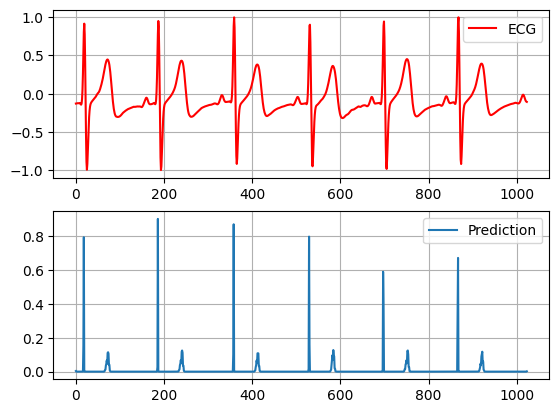

In [19]:
sample = 22
plt.figure(1)
plt.subplot(2,1,1)
plt.plot(newX[sample][:], 'r')
plt.grid()
plt.legend(["ECG"])
plt.subplot(2,1,2)
plt.plot(predictions[sample][:])
plt.grid()
plt.legend(["Prediction"])

In [18]:
threshold = 0.6
def _calc_hrv(peaks_time):
    RRI = np.diff(peaks_time)
    SDNN = np.std(RRI, dtype=float)
    return RRI, SDNN

Text(0.5, 1.0, 'ECG')

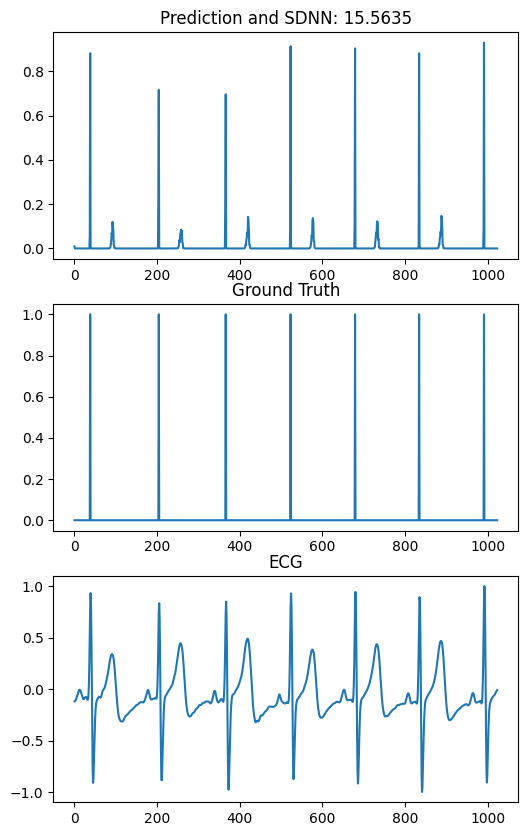

In [20]:
sample = 17
rpeaks = np.where(predictions[sample] > 0.5)[0]
rpeaks = rpeaks * 1/fs*1000
RRI, SDNN = _calc_hrv(rpeaks)
plt.figure(1, figsize=(6,10))
plt.subplot(3,1,1)
plt.plot(predictions[sample][:])
plt.title("Prediction and SDNN: {:.4f}".format(SDNN))
plt.subplot(3,1,2)
plt.plot(newY[sample][:])
plt.title("Ground Truth")
plt.subplot(3,1,3)
plt.plot(newX[sample][:])
plt.title("ECG")

Comparison of the RRIs from aidmed and calculated

In [35]:
ECG = "E:\\ml-data\\masters-thesis\\myDataset\Patryk\\07-05-24_16_56.npy"
RRs = "E:\\ml-data\\masters-thesis\\myDataset\Patryk\\07-05-24_16_56rr.npy"

ECG = np.load(ECG)
ECG = norm_min_max(signal=ECG, lower=-1, upper=1)
RRs = np.load(RRs)

sliced_signal = slice_signal(signal=ECG, start=0, window_in_seconds=10, fs=fs, overlap_factor=0)
newX = []
newY = []

for signal in sliced_signal:
  signal = myConv1D(signal=signal, kernel_length=5, padding='same', mode='boundary_value')
  r_peaks = detect_my_peaks(signal=signal, threshold=0.5)
  r_peak_indexes = np.zeros_like(signal)
  r_peak_indexes[r_peaks] = 1
  newY.append(r_peak_indexes)
  newX.append(signal)

RRIs from the neurokit2k and my

In [37]:
print("My algo")
for i in range(0,1):
  Rpeaks = np.where(newY[i] == 1)[0]
  Rpeaks = Rpeaks * 4
  my_intervals = np.diff(Rpeaks)
  print(my_intervals)

print("Neurokit2k")
for i in range(0,1):
  r_peaks, r_peaks_time = detect_nk(ecg_slice=newX[i][:], fs=250)
  r_peaks_time = r_peaks_time * 1000
  print(np.diff(r_peaks_time))

print("Aidmed")
print(RRs[:10])



My algo
[992 936 888 864 872 824 788 920 948 888]
Neurokit2k
[992. 936. 888. 864. 872. 824. 788. 920. 948. 888.]
Aidmed
[904. 896. 848.   0.   0.   0.   0.   0.   0. 920.]


Tagowanie reczne:

In [22]:
#0-2499:
s10 = [200, 448, 682, 904, 1121, 1337, 1544, 1741, 1970, 2209, 2430]
#2500-4999:
s20 = [136, 324, 507, 717, 960, 1205, 1455, 1698, 1923, 2124, 2334]
#5000-7499:
s30 = [103, 377, 649, 915, 1164, 1386, 1580, 1763, 1960, 2240]
#7500-9999:
s40 = [23, 300, 576, 847, 1102, 1325, 1533, 1728, 1933, 2160, 2388]

s10  = np.array(s10) * 1/fs * 1000
s20  = np.array(s20) * 1/fs * 1000
s30  = np.array(s30) * 1/fs * 1000
s40  = np.array(s40) * 1/fs * 1000

print("0-10s", np.diff(s10))
print("10-20s", np.diff(s20))
print("20-30s", np.diff(s30))
print("30-40s", np.diff(s40))

0-10s [992. 936. 888. 868. 864. 828. 788. 916. 956. 884.]
10-20s [ 752.  732.  840.  972.  980. 1000.  972.  900.  804.  840.]
20-30s [1096. 1088. 1064.  996.  888.  776.  732.  788. 1120.]
30-40s [1108. 1104. 1084. 1020.  892.  832.  780.  820.  908.  912.]
